<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [1]:
push!(LOAD_PATH, ".")
using RobustOptimization
using Ipopt, JuMP, PyPlot
include("ipsolve.jl")
using CSV
using PyCall
using PyPlot
using ScikitLearn

In [2]:
@sk_import preprocessing: StandardScaler
@sk_import model_selection: train_test_split

PyObject <function train_test_split at 0x7f12205ee268>

In [3]:
df = CSV.read("datasets/covtype.csv", nullable=false);
for k in 1:length(df[:,end])
    if df[k,end] == 2.0
        df[k,end] = 1
    else
        df[k,end] = -1
    end
end

In [4]:
df_scaled = fit_transform!(StandardScaler(), convert(Array, df[:,1:end-1]))
df_clean = hcat(ones(length(df[:,end])),df_scaled, df[:,end]);

In [5]:
xtr, xte, ytr, yte = train_test_split(df_clean[:,1:end-1], df_clean[:,end], train_size=0.01)
df_train = hcat(xtr, ytr)
df_test = hcat(xte, yte);

In [41]:
nbfeatures = size(df_train)[2]-1

# ambiguity = "KLdivergence"
ambiguity = "wasserstein"
# srand(10)
N = size(df_train)[1]
ϵ = 0.00
verbosity = 100
itmax = 100000
# itmax = 20000
α = 0.5
sample = 4

robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
projParams = ProjParams(Int(1e6), 1e-5, sample)
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [42]:
x0 = ones(size(robustModel.descent_direction))
xalg = run_algo(x0, df_train, robustModel, optParams, projParams)
xrobust = getsolution(xalg, ambiguity, nbfeatures)

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 1850

55-element Array{Float64,1}:
  0.850321
 -2.83975 
 -1.80465 
  2.26675 
  2.49839 
 -1.3044  
 -0.380295
  1.75605 
  1.80404 
  0.774949
  1.49345 
  3.53235 
 -0.431025
  ⋮       
  5.30887 
  1.92854 
  0.97601 
  1.58975 
  3.82702 
  1.00791 
  0.721681
  1.00214 
  1.00339 
 -1.7816  
 -2.39684 
 -0.502186

In [43]:
function error_on_test(data,the)
    RG = 0
    for i in 1:length(data[:,end])
        if (1/(1+exp(the'*data[i,1:end-1])) > 0.5) & (data[i,end] == -1)
             RG = RG+1
        end
        if (1/(1+exp(-the'*data[i,1:end-1])) > 0.5) & (data[i,end] == 1)
             RG = RG+1
        end
    end
    return 100-RG*100/length(data[:,end])
end

error_on_test (generic function with 1 method)

In [44]:
# print(" train = ")
# print(error_on_test(df_train, xrobust))
print(" test  = ")
print(error_on_test(df_test, xrobust))

 train = 36.230636833046475 test  = 35.48457759187207

In [9]:
function search_epsilon(step, Max, seed)
    aa = []
    bb = []
    for ϵ in 0:step:Max
        println("epsilon = ", ϵ)
        robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
        projParams = ProjParams(Int(1e6), 1e-5, sample)
        optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);
        x0 = ones(size(robustModel.descent_direction))
        srand(seed)
        xalg = run_algo(x0, df_train, robustModel, optParams, projParams)
        xrobust = getsolution(xalg, ambiguity, nbfeatures) 
        push!(aa, error_on_test(df_train, xrobust))
        push!(bb, error_on_test(df_test, xrobust))
        println(" ")
    end
    return aa, bb
end

function search_alpha(Max, seed)
    aa = []
    bb = []
    for i in 0:Max
        alpha = 10^(i-1)
        robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
        projParams = ProjParams(Int(1e6), 1e-5, sample)
        optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);
        x0 = ones(size(robustModel.descent_direction))
        srand(seed)
        xalg = run_algo(x0, df_train, robustModel, optParams, projParams)
        xrobust = getsolution(xalg, ambiguity, nbfeatures) 
        push!(aa, error_on_test(df_train, xrobust))
        push!(bb, error_on_test(df_test, xrobust))
    end
    return aa, bb
end

search_alpha (generic function with 1 method)

In [45]:
aa, bb = search_epsilon(0.1,1,2)

epsilon = 0.0
100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 1850

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 1850

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 1850

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 1850

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 1850

(Any[40.1893, 33.9415, 28.7435, 29.4664, 32.8227, 35.284, 34.3546, 34.2169, 30.4991, 30.8778, 29.6213], Any[39.6129, 34.4359, 28.1783, 29.7607, 32.2777, 36.1652, 34.7596, 34.1723, 31.0616, 30.1977, 29.0642])

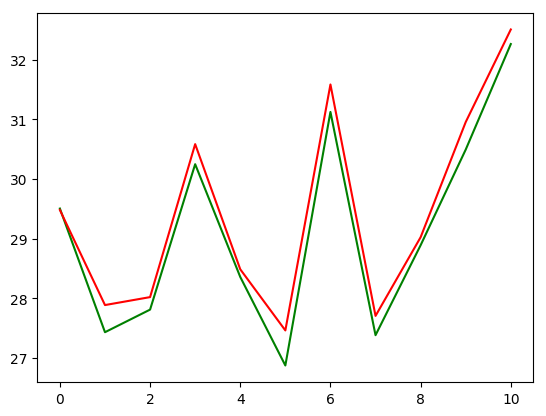

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f7602960898>

In [29]:
plot(aa, color = "green")
plot(bb, color = "red")

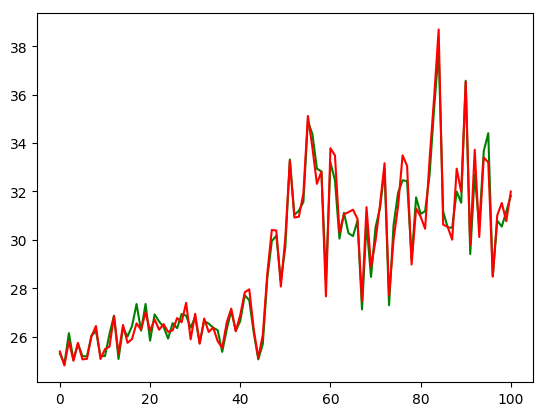

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa79274eb00>

In [11]:
plot(aa, color = "green")
plot(bb, color = "red")

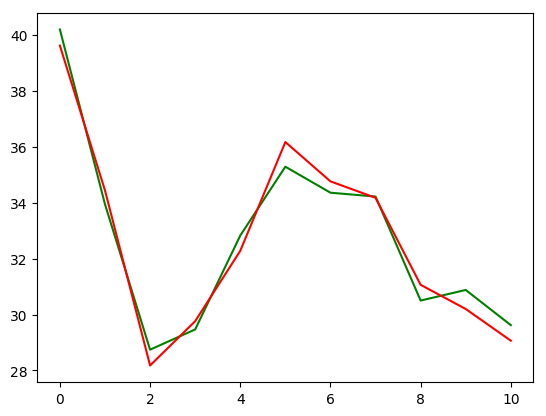

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa7914723c8>

In [46]:
plot(aa, color = "green")
plot(bb, color = "red")

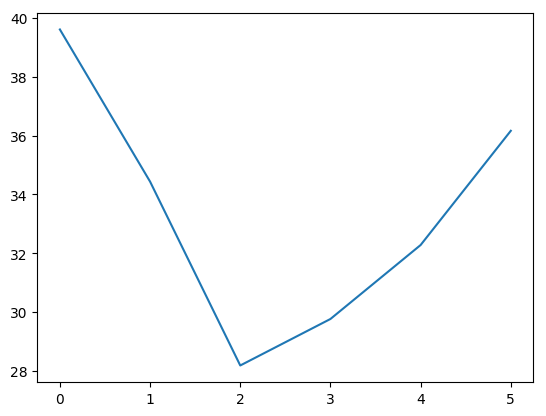

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa7913f28d0>

In [49]:
plot(bb[1:6])